In [1]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

import tests

In [2]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = np.rint(resize(lenna_rgb_512x512, (256, 256)) * 255).astype('uint8')
lenna_gray_512x512 = np.rint(rgb2gray(lenna_rgb_512x512) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(resize(lenna_gray_512x512, (256, 256)) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')

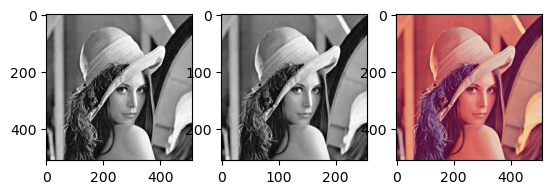

In [3]:
lenna_yuv_512x512 = np.rint(rgb2yuv(lenna_rgb_512x512)*255).astype('uint8')
fig, axs = plt.subplots(1, 3)
axs[0].imshow(lenna_gray_512x512, cmap='gray')
axs[1].imshow(lenna_gray_256x256, cmap='gray')
axs[2].imshow(lenna_rgb_512x512)
plt.show()

In [4]:
# GRADED CELL: FractalCompressionParams

FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride'
    ]
)

In [5]:
# GRADED CELL: BlockTransform

BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])

In [6]:
def derive_num_bits(length, stride):
#     if length%stride != 0:
#         raise f'Invalid length({length}) or stride({stride})'
    return np.ceil(np.log2(length // stride)).astype(int)

In [7]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

In [8]:
# GRADED CELL: find_block_transform

def find_block_transform(image, resized_image, x, y, block_size, stride):
    _direction = [0, 1] # noflip, flip
    _angle = [0, 1, 2, 3] # 0, 90, 180, 270
    converts = [[direction, angle] for direction in _direction for angle in _angle]
    source_row = image.shape[0]
    source_col = image.shape[1]
    
    destination_row = resized_image.shape[0]
    destination_col = resized_image.shape[1]
    
    
    t_x,t_y, t_di, t_tr = 0,0,0,0
    best_dist = float('inf')
    dist = 0
    R = image[(x)*block_size : (x+1)*block_size, (y)*block_size : (y+1)*block_size].copy()
    D1: np.array
    D: np.array
    R_sum = np.sum(R)

    for i in range(0, destination_row//block_size, stride):
        for j in range(0, destination_col//block_size, stride):
            D = resized_image[(i)*block_size : (i+1)*block_size, (j)*block_size : (j+1)*block_size].copy()
            D = 0.75*D
            D_sum = np.sum(D)
            di =(-D_sum + R_sum)/(block_size**2)
            
            for direction, angle in converts:
                for _ in range(2):
                    if direction:
                        D1 = np.fliplr(D).copy()
                    else:
                        D1 = D.copy()

                    D1 = np.rot90(D1, k=angle)
                    di = -di
                    D1 += di
                    dist = mse(D1, R)
                    tr = (direction << 2) | angle
                    if dist < best_dist:
                        best_dist = dist
                        t_x = i
                        t_y = j
                        t_di = di
                        t_tr = tr
#     print("Transform: ", BlockTransform(x=t_x, y=t_y, di=t_di, tr=t_tr))
    return BlockTransform(x=t_x, y=t_y, di=t_di, tr=t_tr)

In [9]:
# GRADED CELL: perform_transform

def perform_transform(image, resized_image, transforms, block_size):
    if (image.shape[0]*image.shape[1])//block_size**2 != len(transforms):
        raise IndexError(f'Debil krivorukiy: {image.shape[0]},{image.shape[1]},{len(transforms)}')
    
    source_row = image.shape[0]
    source_col = image.shape[1]
    
    destination_row = resized_image.shape[0]
    destination_col = resized_image.shape[1]
    
    transformed_image = image.copy()
    c = 1
    for i in range(0, source_row//block_size):
        for j in range(0, source_col//block_size):
            block_transform = transforms[-c]
            c += 1
#             print("Transform: ", block_transform)
            
            D = resized_image[(block_transform.x)*block_size : (block_transform.x+1)*block_size, 
                              (block_transform.y)*block_size : (block_transform.y+1)*block_size].copy()

            if(block_transform.tr & 0x04):
                R = np.fliplr(D).copy()
            else:
                R = D.copy()
            R = 0.75*np.rot90(R, k=block_transform.tr & 0x03) + block_transform.di
            transformed_image[(i)*block_size : (i+1)*block_size, (j)*block_size : (j+1)*block_size] = R
    return transformed_image

In [10]:
tests.test_transform(find_block_transform, perform_transform)

'OK'

In [11]:
# GRADED CELL: BitBuffer

class BitBuffer:
    def __init__(self, buffer=None, SP=0):
        self._buffer = buffer or bytearray()
        self.SP = SP
        self.buf = np.uint8(0) # offsetted last byte in _buffer
        self.f = True
        if self.SP and len(self._buffer):
            self.buf = self._buffer[-1] >> (8 - self.SP%8)
#             print((8 - self.SP%8), self.buf, bin(self.buf), self.SP, self._buffer[-3:])
    def to_bytearray(self):
        return self._buffer

    def push(self, x, n_bits):
        n1 = n_bits
        y = np.uint32(0)
        while(n1):
            y <<= 1
            y |= x & 0x01
            x >>= 1
            n1 -= 1
        c = 8 - self.SP % 8
        is_buf_clear = c==8
        n1 = n_bits
        while(n1):
            self.buf <<= 1
            self.buf |= (y & 0x01)
            y >>= 1
            n1 -= 1
            c -= 1
            self.SP += 1
            if c==0:
                if is_buf_clear:
                    self._buffer.append(self.buf)
                else:
                    self._buffer[-1] = self.buf
                    is_buf_clear = True
                self.buf = np.uint8(0)
                c = 8
        if c!=0 and c!=8:
            if is_buf_clear:
                self._buffer.append(self.buf << c)
            else:
                self._buffer[-1] = self.buf << c

        
            
    def pop(self, n_bits):
        c = self.SP % 8
        if self.SP%8 ==0:
            c = 8
        self.buf = self._buffer[-1] >> (8 - c)
        e = np.uint8(255) << (8 - c)
        y = np.uint32(0)
        n1 = n_bits
        while(n1):
            y <<= 1
            y += (self.buf & 0x01)
            self.buf >>= 1
            c -= 1
            e <<= 1
            self.SP -= 1
            if c==0:
                del self._buffer[-1]
                if len(self._buffer):
                    self.buf = self._buffer[-1]
                else:
                    self.buf = 0
                    break
                c = 8
                e = np.uint8(255)
            n1 -= 1
        if len(self._buffer)>0:
            self._buffer[-1] = self._buffer[-1] & e
            self.buf = self._buffer[-1] >> (8 - self.SP%8)

        x = np.uint32(0)
        while(n_bits):
            
            x <<= 1
            x |= (y & 0x01)
            y >>= 1
            n_bits -= 1
        
        return np.int32(x)

In [12]:
tests.test_bit_buffer(BitBuffer)

'OK'

In [13]:
# GRADED CELL: FractalCompressor

class FractalCompressor:
    def __init__(self):
        self._num_bits_ver = derive_num_bits(512, 1) # height bits
        self._num_bits_hor = derive_num_bits(512, 1) # width bits
        self._num_bits_pix = 7 # intensity_scale bits derive_num_bits( # YOUR CODE HERE )
        self._num_bits_tfm = 7 # spatial_scale bits derive_num_bits( # YOUR CODE HERE )
        self._num_bits_bls = 6 # block_size bits
        self._num_bits_clr = 1 # is_colored bits
        self._num_bits_str = 5 # stride bits
        
        self._num_bits_x = 8
        self._num_bits_y = 8
        
        self.buf_SP = 0
        self.buffer = None
        self.stride = 1
        
    def _add_header(self, buffer:BitBuffer, params:FractalCompressionParams):
        print(params)
        buffer.push(params.height, self._num_bits_ver)
        buffer.push(params.width, self._num_bits_hor)
        buffer.push(params.is_colored, self._num_bits_clr)
        buffer.push(params.block_size, self._num_bits_bls)
        buffer.push(int(params.spatial_scale*100), self._num_bits_tfm)
        buffer.push(int(params.intensity_scale*100), self._num_bits_pix)
        buffer.push(params.stride, self._num_bits_str)
        
    def _read_header(self, buffer:BitBuffer)->FractalCompressionParams:
        stride = buffer.pop(self._num_bits_str)
        intensity_scale = buffer.pop(self._num_bits_pix)/100
        spartial_scale = buffer.pop(self._num_bits_tfm)/100
        block_size = buffer.pop(self._num_bits_bls)
        is_colored = buffer.pop(self._num_bits_clr)
        width = buffer.pop(self._num_bits_hor)
        height = buffer.pop(self._num_bits_ver)
        params = FractalCompressionParams(
            height,
            width,
            is_colored,
            block_size,
            spartial_scale,
            intensity_scale,
            stride
        )
        
        
#         print(params, self._num_bits_hor)
        return params
    
    def _add_to_buffer(self, buffer:BitBuffer, transform:BlockTransform, stride):
        buffer.push(transform.x//stride, self._num_bits_x)
        buffer.push(transform.y//stride, self._num_bits_y)
        buffer.push(int(transform.di*(10**3)), 32)
        buffer.push(transform.tr, 3)

    def _read_transform(self, buffer:BitBuffer, stride)->BlockTransform:
        tr = buffer.pop(3)
        di = buffer.pop(32)/(10**3)
        y = buffer.pop(self._num_bits_y)*stride
        x = buffer.pop(self._num_bits_x)*stride
        transform = BlockTransform(x,y,di,tr)
        return transform
    
    def _ifs2buf(self, params:FractalCompressionParams, transformations)->BitBuffer:
        buffer = self.buffer #or BitBuffer()
        
        for t in transformations:
            self._add_to_buffer(buffer, t, params.stride)

        return buffer
    
    def _buf2ifs(self, buffer:BitBuffer, params:FractalCompressionParams):
        
        num_transforms = int(params.height * params.width / params.block_size ** 2)
        transforms = [
            self._read_transform(buffer, params.stride)
            for _ in range(num_transforms)
        ]
        
        return params, transforms
        
        
    def compress(self, image, is_colored=False, block_size=8, stride=2,
                 spatial_scale=0.5, intensity_scale=0.75):
        params = FractalCompressionParams(image.shape[0], image.shape[1],
                                            is_colored, block_size,
                                            spatial_scale, intensity_scale, stride)
        source_image = image.copy()
        
        resized_image = np.rint(resize(source_image, 
                                           (int(params.height*spatial_scale), 
                                            int(params.width*spatial_scale)))*255).astype('uint8')
        xs = [i for i in range(params.height//block_size)]
        ys = [j for j in range(params.width//block_size)]
        transformations = []
        for x,y in tqdm(itertools.product(ys, xs), total=len(xs)*len(ys)):
            transform = find_block_transform(
                source_image, resized_image,
                x, y, block_size, stride
            )
            transformations.append(transform)
        
        buffer = self._ifs2buf(params, transformations)
        return buffer, params

    def compress2(self, image, quality=50):
        
#         stride = 10 - quality//10 + 1
        if 0<=quality<=5:
            stride = 4
            block_size = 32
        elif quality<=10:
            stride = 2
            block_size = 32
        elif quality<=20:
            block_size = 16
            stride = 12
        elif quality<=30:
            block_size = 16
            stride = 8
        elif quality<=40:
            block_size = 16
            stride = 4
        elif quality<=50:
            block_size = 16
            stride = 2
        elif quality<=60:
            block_size = 8
            stride = 16
        elif quality<=70:
            block_size = 8
            stride = 12
        elif quality<=80:
            block_size = 8
            stride = 6
        elif quality<=90:
            block_size = 4
            stride = 8
        elif quality<=100:
            block_size = 4
            stride = 6
        print(stride, block_size)
        
        self.stride = stride
        self._num_bits_x = derive_num_bits(image.shape[0], stride)
        self._num_bits_y = derive_num_bits(image.shape[1], stride)
        
        
        self.buffer = BitBuffer()
        
        if not is_colored(image):
            buffer, params = self.compress(image, is_colored=False, block_size=block_size, stride=stride)
            self._add_header(buffer, params)
            self.buf_SP = buffer.SP
            self.buffer._buffer.append(8 - self.buf_SP%8)
            return buffer.to_bytearray()
        
        img_y = image[:,:,0]
        img_u = image[:,:,1]
        img_v = image[:,:,2]
        self.compress(img_y, is_colored=True, block_size=block_size, stride=stride)
        self.compress(img_u,is_colored=True, block_size=block_size, stride=stride)
        buffer,params = self.compress(img_v,is_colored=True, block_size=block_size, stride=stride)
        self._add_header(buffer, params)
        self.buf_SP = buffer.SP
        self.buffer._buffer.append(8 - self.buf_SP%8)
        return buffer.to_bytearray()
    
    def init_decompress(self, byte_array):
        ba = byte_array.copy()
        self.buf_SP = ba[-1]
        self.buf_SP = (len(ba)-1)*8 - self.buf_SP
        del ba[-1]
        self.buffer = BitBuffer(ba, self.buf_SP)
        self.params = self._read_header(self.buffer)
        self.transforms = [[],[],[]]
        self._num_bits_x = derive_num_bits(self.params.height, self.params.stride)
        self._num_bits_y = derive_num_bits(self.params.width, self.params.stride)
        _, self.transforms[0] = self._buf2ifs(self.buffer, self.params)

        if self.params.is_colored:
            _, self.transforms[1] = self._buf2ifs(self.buffer, self.params)
            _, self.transforms[2] = self._buf2ifs(self.buffer, self.params)


    def decompress(self, byte_array, num_iters=10):
        self.init_decompress(byte_array)
        image = 125*np.ones([self.params.height, self.params.width],dtype=np.uint8)
        resized_image = np.rint(resize(image, (image.shape[0]*self.params.spatial_scale, 
                                               image.shape[1]*self.params.spatial_scale)) * 255).astype('uint8')
        params, transforms = self.params, self.transforms
        block_size = params.block_size
        imgs = []
        
        for t in range(3):
            for _ in range(num_iters):
                image = perform_transform(image, resized_image, transforms[t], block_size)
                resized_image = np.rint(resize(image, (image.shape[0]*params.spatial_scale, 
                                                   image.shape[1]*params.spatial_scale)) * 255).astype('uint8')
            if not params.is_colored:
                return image
            imgs.append(image.copy())
            if len(imgs)==3:
                break
            image = 125*np.ones([params.height, params.width],dtype=np.uint8)
            resized_image = np.rint(resize(image, (image.shape[0]*params.spatial_scale, 
                                               image.shape[1]*params.spatial_scale)) * 255).astype('uint8')
        shape = (imgs[0].shape[0], imgs[0].shape[1], 1)
        result = np.concatenate((np.reshape(imgs[2], shape), np.reshape(imgs[1], shape),np.reshape(imgs[0], shape)), axis=2)
        return result

In [14]:
comp = FractalCompressor()

In [15]:
result_16x4 = comp.compress2(lenna_gray_256x256, 90)

8 4


100%|██████████████████████████████████████| 4096/4096 [00:24<00:00, 166.15it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=8)


In [16]:
lenna_gray_256x256.size / len(result_16x4)

2.8435805093938473

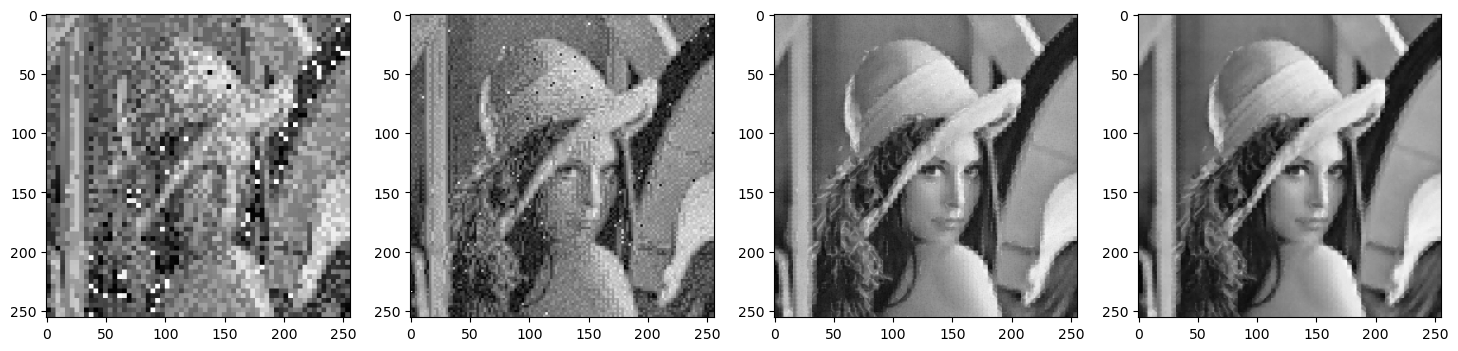

In [17]:
n_iters = [1, 2, 4, 8]
imgs = [comp.decompress(result_16x4, n).copy() for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
#     print(imgs[index].size)
    axs[index].imshow(imgs[index], cmap='gray')
plt.show()

In [18]:
res = comp.compress2(lenna_rgb_256x256, 70)

2 16


100%|████████████████████████████████████████| 256/256 [00:01<00:00, 161.16it/s]

FractalCompressionParams(height=256, width=256, is_colored=True, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=2)


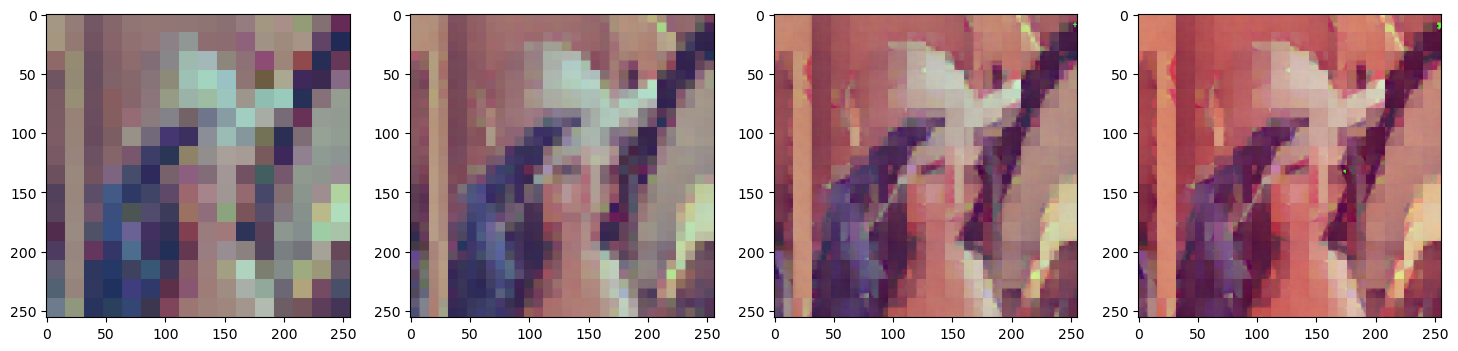

In [19]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(res, n).copy() for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index])
plt.show()

In [20]:
comp = FractalCompressor()

In [21]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

In [22]:
quality = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

def test_image(img):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images])/img.size
#     print(compression_rates)
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs

In [23]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    for image in collection:
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

4 32


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 2107.97it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 32


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 610.88it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=2)
12 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2192.01it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=12)
8 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2312.24it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=8)
4 16


100%|████████████████████████████████████████| 256/256 [00:00<00:00, 631.41it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 16


100%|████████████████████████████████████████| 256/256 [00:01<00:00, 159.96it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=2)
16 8


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2573.62it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=16)
12 8


100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 677.46it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=12)
6 8


100%|██████████████████████████████████████| 1024/1024 [00:03<00:00, 302.43it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=6)
8 4


100%|██████████████████████████████████████| 4096/4096 [00:24<00:00, 167.87it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=8)
6 4


100%|███████████████████████████████████████| 4096/4096 [00:52<00:00, 77.34it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=6)


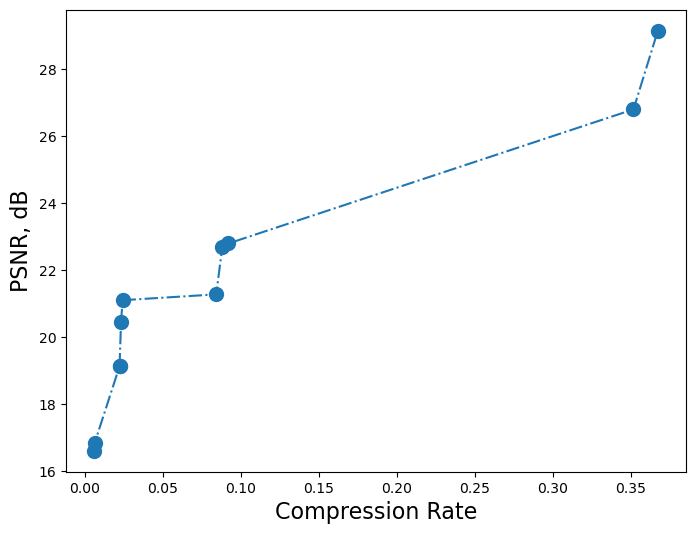

In [24]:
test_and_plot_collection([lenna_gray_256x256])

4 32


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 2104.29it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 32


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 590.20it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=2)
12 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2639.98it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=12)
8 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2460.62it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=8)
4 16


100%|████████████████████████████████████████| 256/256 [00:00<00:00, 675.27it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 16


100%|████████████████████████████████████████| 256/256 [00:01<00:00, 161.10it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=2)
16 8


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2677.19it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=16)
12 8


100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 661.34it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=12)
6 8


100%|██████████████████████████████████████| 1024/1024 [00:03<00:00, 310.10it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=6)
8 4


100%|██████████████████████████████████████| 4096/4096 [00:24<00:00, 170.42it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=8)
6 4


100%|███████████████████████████████████████| 4096/4096 [00:52<00:00, 77.66it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=6)
4 32


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 2224.86it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 32


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 607.04it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=2)
12 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2357.59it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=12)
8 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2402.67it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=8)
4 16


100%|████████████████████████████████████████| 256/256 [00:00<00:00, 666.99it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 16


100%|████████████████████████████████████████| 256/256 [00:01<00:00, 168.00it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=2)
16 8


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2721.50it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=16)
12 8


100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 672.88it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=12)
6 8


100%|██████████████████████████████████████| 1024/1024 [00:03<00:00, 310.63it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=6)
8 4


100%|██████████████████████████████████████| 4096/4096 [00:23<00:00, 177.46it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=8)
6 4


100%|███████████████████████████████████████| 4096/4096 [00:53<00:00, 76.40it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=6)
4 32


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 2143.93it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 32


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 617.94it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=32, spatial_scale=0.5, intensity_scale=0.75, stride=2)
12 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2582.23it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=12)
8 16


100%|███████████████████████████████████████| 256/256 [00:00<00:00, 2422.17it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=8)
4 16


100%|████████████████████████████████████████| 256/256 [00:00<00:00, 691.23it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=4)
2 16


100%|████████████████████████████████████████| 256/256 [00:01<00:00, 165.64it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=16, spatial_scale=0.5, intensity_scale=0.75, stride=2)
16 8


100%|█████████████████████████████████████| 1024/1024 [00:00<00:00, 2750.99it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=16)
12 8


100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 673.01it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=12)
6 8


100%|██████████████████████████████████████| 1024/1024 [00:03<00:00, 308.03it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=8, spatial_scale=0.5, intensity_scale=0.75, stride=6)
8 4


100%|██████████████████████████████████████| 4096/4096 [00:23<00:00, 174.37it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=8)
6 4


100%|███████████████████████████████████████| 4096/4096 [00:52<00:00, 78.15it/s]


FractalCompressionParams(height=256, width=256, is_colored=False, block_size=4, spatial_scale=0.5, intensity_scale=0.75, stride=6)


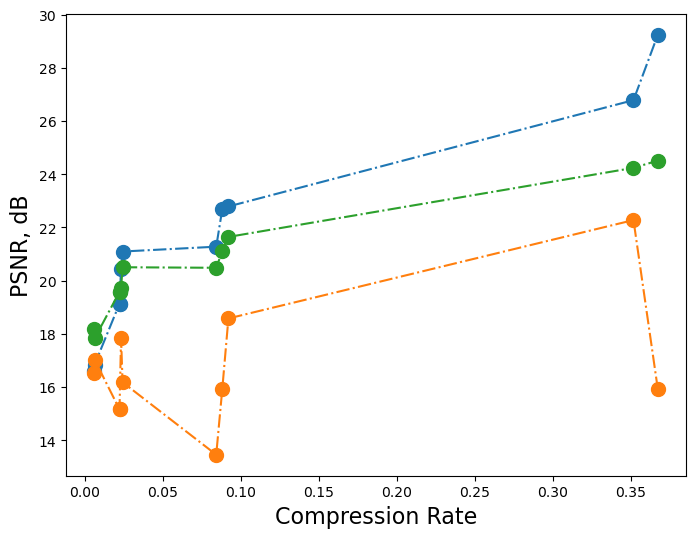

In [25]:
collection = []
for image_name in os.listdir('test_files'):
    image = resize(io.imread(os.path.join('test_files', image_name)), (256, 256))
    if is_colored(image):
        image = np.rint(rgb2gray(image) * 255).astype('uint8')
    collection.append(image)
test_and_plot_collection(collection)